In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/retaildataset/stores data-set.csv
/kaggle/input/retaildataset/Features data set.csv
/kaggle/input/retaildataset/sales data-set.csv


# **Wallmart sales prediction using 4 neural networks**

On 2014, Wallmart made a competition about data analysis of 45 stores. The competition had 2 main objectives: **Department-wide sales prediction for each store** and **markdowns effect on holiday weeks analysis**. Regarding machine learning algorithms training, holiday weeks are weighted 5 times more than the others.

The dataset composed of 3 csv files:

- **"sales.csv"**

  Contains the weekly sales records by date, store and department. It's variable columns are:
   
  - **Date**: Weekly record date.
  - **Store**: The store id.
  - **Dept**: The department id.
  - **Weekly_Sales**: The corresponding weekly sales.
  - **IsHoliday**: If the week is part of a main holiday (Super Bowl, Labor Day, Thanksgiving or Christmas).
  
  Some noticeable details about the data:
  
  - Some **Weekly_Sales** values are negative. That can be due to product refunds. We suppose refunds are already included on all weekly records (recorded sales = sales - refunds) so negative values are viewed as the rest.
  - For a specific week not always there will the records of all the departments of all the stores. Some may be missing.

- **"stores.csv"**

  Contains basic info about each store (type and size). Variables:
  - **Store**: The store id.
  - **Type**: Store type.
  - **Size**: Store size.

- **"features.csv"**
 
  Contains info about each week features:
  - **Date**: Weekly record date.
  - **Store**: The store id. 
  - **Temperature**: Mean temperature of the store's region.
  - **Fuel_Price**: Fuel prize of the region.
  - **CPI**: Consumer Prize Index of the region.
  - **Unemployment**: Unemployment rate of the region.
  - **MarkDown1-5**: Anonymized data about the markdowns of each store.
 
  Noticeable details:
  - For an specific week not always there's info about all the markdowns (sometimes some **MarkDown** columns don't have a value).

Dataset date range spans from **05/02/2010** to **26/07/2013**, though some variables are available in a reduced range:
- **Weekly_Sales**: From **05/02/2010** to **26/10/2012**. The competition asked for the prediction from the end of this date range to the end of the dataset date range (**02/11/2012** - **26/07/2013**).
- **MarkDown1-5**: From **11/11/2011** to **26/07/2013**.
- **CPI** and **Unemployment**: From **05/02/2010** to **26/04/2013**.

In addition to the occasional lack of data commented previously.

# **0. Data import and first data cleaning**

First we will assign the data types of each variable.
- Store, Dept, IsHoliday and Type will be categorical.
- Date will be datetime.
- Temperature, Fuel Price, CPI, Unemployment, MarkDown1-5 and Weekly_Sales will be float64.

Also, we will add the following variables:
- **MarkDowns**: The sum of the values of the 5 markdown columns.
- **Week**: The week of the year, extracted from **Date**.
- **Year**: The year, extracted from **Date**.
- **Weight**: The weight of each record.

In [2]:
import pandas as pd

# Data import
features=pd.read_csv("/kaggle/input/retaildataset/Features data set.csv")
stores=pd.read_csv("/kaggle/input/retaildataset/stores data-set.csv")
sales=pd.read_csv("/kaggle/input/retaildataset/sales data-set.csv")

# Now we setup the data types of each column.
features["Store"]=features["Store"].astype("category")
features["Date"]=pd.to_datetime(features["Date"],dayfirst=True)
features["IsHoliday"]=features["IsHoliday"].map({True:1,False:0}).astype("category")
features["Week"]=features["Date"].dt.isocalendar().week
features["Year"]=features["Date"].dt.isocalendar().year
for i in range(1,6): # A total markdown column is created. It sums the value of the 5 markdown columns.
  if i==1:
    features["MarkDowns"]=features["MarkDown%s" % i]  
  else:
    features["MarkDowns"]=features["MarkDowns"]+features["MarkDown%s" % i]  
featsfloatcols=["Temperature","Fuel_Price","CPI", "Unemployment", "MarkDowns"]+["MarkDown%s" % i for i in range(1,6)]
features[featsfloatcols]=features[featsfloatcols].astype("float64")
features["Weight"]=features["IsHoliday"].map({1:5,0:1}).astype("int64") # We set up the weights of each row. Holiday weeks have a weight 5 times larger than the others.

stores["Store"]=stores["Store"].astype("category")
stores["Type"]=stores["Type"].astype("category")

sales["Store"]=sales["Store"].astype("category")
sales["Dept"]=sales["Dept"].astype("category")
sales["IsHoliday"]=sales["IsHoliday"].map({True:1,False:0}).astype("category")
sales["Date"]=pd.to_datetime(sales["Date"],dayfirst=True)

## **Original dataframes**

In [3]:
sales

,Store,Dept,Date,Weekly_Sales,IsHoliday
0,1,1,2010-02-05,24924.50,0
1,1,1,2010-02-12,46039.49,1
2,1,1,2010-02-19,41595.55,0
3,1,1,2010-02-26,19403.54,0
4,1,1,2010-03-05,21827.90,0
...,...,...,...,...,...
421565,45,98,2012-09-28,508.37,0
421566,45,98,2012-10-05,628.10,0
421567,45,98,2012-10-12,1061.02,0
421568,45,98,2012-10-19,760.01,0


In [4]:
features

,Store,Date,Temperature,Fuel_Price,MarkDown1,MarkDown2,MarkDown3,MarkDown4,MarkDown5,CPI,Unemployment,IsHoliday,Week,Year,MarkDowns,Weight
0,1,2010-02-05,42.31,2.572,NaN,NaN,NaN,NaN,NaN,211.096358,8.106,0,5,2010,NaN,1
1,1,2010-02-12,38.51,2.548,NaN,NaN,NaN,NaN,NaN,211.242170,8.106,1,6,2010,NaN,5
2,1,2010-02-19,39.93,2.514,NaN,NaN,NaN,NaN,NaN,211.289143,8.106,0,7,2010,NaN,1
3,1,2010-02-26,46.63,2.561,NaN,NaN,NaN,NaN,NaN,211.319643,8.106,0,8,2010,NaN,1
4,1,2010-03-05,46.50,2.625,NaN,NaN,NaN,NaN,NaN,211.350143,8.106,0,9,2010,NaN,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,45,2013-06-28,76.05,3.639,4842.29,975.03,3.00,2449.97,3169.69,NaN,NaN,0,26,2013,11439.98,1
8186,45,2013-07-05,77.50,3.614,9090.48,2268.58,582.74,5797.47,1514.93,NaN,NaN,0,27,2013,19254.20,1
8187,45,2013-07-12,79.37,3.614,3789.94,1827.31,85.72,744.84,2150.36,NaN,NaN,0,28,2013,8598.17,1
8188,45,2013-07-19,82.84,3.737,2961.49,1047.07,204.19,363.00,1059.46,NaN,NaN,0,29,2013,5635.21,1


In [5]:
stores

,Store,Type,Size
0,1,A,151315
1,2,A,202307
2,3,B,37392
3,4,A,205863
4,5,B,34875
5,6,A,202505
6,7,B,70713
7,8,A,155078
8,9,B,125833
9,10,B,126512


Now we modify **sales** dataframe so it can get future **Weekly_Sales** values.

In [6]:
import numpy as np
futuresales=sales[["Store","Dept"]].drop_duplicates()
futuresales["Weekly_Sales"]=np.nan
futuredates=features[features["Date"]>sales["Date"].max()][["Store","Date","IsHoliday"]]
futuresales=futuresales.merge(futuredates,on="Store", how="outer")
salesV2=pd.concat([sales,futuresales])

# **1. Data cleaning and analysis**

Our data processing has the following stages:

- **Merge** : The 3 dataframes (stores, sales, features) are merged in order to obtain all the info of each weekly record at the same time.

- **Cook**: Apply one-hit encoding to each categorical variable (Store, Dept, IsHoliday and Type).

  Week variable is kept as numeric, since it has a natural order and a concept of continuity (week 34 goes after 33 and before 35). Due to its nature, its relation with sales has to be periodical (1 year = 52 weeks -> S(w): S(w+52n)=S(w), nϵℤ). We expect the algorithm to end up with a similar conclusion.

- **Serve**: Train-test data split according to one of the following criteria:
  - **Random split**: Data records with sales are shuffled and are split following a given ratio.
  - **Date split**: Data records with sales are split according to a given date. The previous records to this date are shuffled and form the train set, the rest form the test set.
  - **Past-future split**: The records inside the sales data range (until 26/10/2012) are used as a train set. The rest, the ones we have to actually predict, form the test set. 

  Furthermore, a standard scaling is applied  to the data following the train set data distribution. This scaling shifts and scales the data so each column has mean=0 and variance=1. This way, neural networks can learn the date with more ease.

In the analysis part, here we focus on the effect of markdowns on sales and the possible meaning of the anonymized columns.

## **Function definition**
First the functions used in the data processing are defined.

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import numpy as np

def isCategory(data,col):
  '''
  Check if a column is categorical.
  '''
  try:
    return data[col].dtype=="category"
  except:
    return False

def CategCols(data):
  '''
  Retuns a list with the names of all categorical columns.
  '''
  return [col for col in data.columns if isCategory(data,col)==True]

def negFix0(oldval):
  '''
  max(0,x) function.
  '''
  if oldval<0: return 0
  else: return oldval

def fixFutureWS(WS):
  '''
  This function assigns again all future sales as NaNs,
  since when a sum groupby is applied, NaNs become 0.
  '''
  if WS==0: return np.nan
  else: return WS

def featuresMod(markdowns, CPI_Unemp):
  '''
  Modifies the features dataframe in case we don't want to work with
  columns MarkDown and CPI and Unemployment
  '''
  moddedFeats=features.copy()
  for i in range(1,6):
    if markdowns!="all":
      moddedFeats=moddedFeats.drop("MarkDown%s" % i, axis=1)
  if markdowns==False:
    moddedFeats=moddedFeats.drop("MarkDowns", axis=1)
  if CPI_Unemp==False:
    moddedFeats=moddedFeats.drop(["CPI", "Unemployment"], axis=1)
  return moddedFeats.dropna()

def salesMod(negWS):
  '''
  Modifies the sales dataframe. Negative Weekly_Sales values can be set to 0, dropped
  or remain untouched. In our case, we remain them untouched.
  '''
  moddedSales=salesV2.copy()
  if negWS=="Keep":
    pass
  elif negWS=="Set0":
    moddedSales["Weekly_Sales"]=moddedSales["Weekly_Sales"].apply(lambda x: negFix0(x))
  elif negWS=="Drop":
    moddedSales=moddedSales.query("Weekly_Sales >= 0 | Weekly_Sales != Weekly_Sales")
  return moddedSales

def dataMerge(feats, sales, Detail):
  '''
  Merges the 3 dataframes and it groups the data by store if needed.
  In our case, the data detail has to be department-wide.
  '''
  if Detail=="Store":
    GBSsales=sales.groupby(by=["Date","IsHoliday","Store"]).sum().reset_index()
    GBSsales["Weekly_Sales"]=GBSsales["Weekly_Sales"].apply(lambda x: fixFutureWS(x))
    mergedData=GBSsales.merge(stores, how="inner", on="Store")
  elif Detail=="Dept":
    mergedData=sales.merge(stores, how="right", on="Store")
  mergedData=mergedData.merge(feats, how="right", on=["Store","Date","IsHoliday"])
  return mergedData

def dataCook(data):
  '''
  Generates the One-Hit-Encodings of categorical variables.
  '''
  cookedData=data.copy()
  cookedData=cookedData.drop("Year", axis=1)
  for col in CategCols(cookedData):
    OHEdata=pd.get_dummies(cookedData[col], prefix=col)
    cookedData=cookedData.join(OHEdata)
    cookedData=cookedData.drop(col, axis=1)
  return cookedData

def dArray(data):
  '''
  Transforms the dataframes to a dictionary with numpy arrays.
  '''
  op={}
  op["X"]=data.drop(["Weekly_Sales","Weight","Date"],axis=1).values
  op["y"]=data["Weekly_Sales"].values.reshape(-1,1)
  op["w"]=data["Weight"].values.reshape(-1,1)
  op["d"]=data["Date"].values.reshape(-1,1)
  return op

def dataServe(data, testSize, splitDate, futureTest):
  '''
  Train-Test data split. It can do it in 3 ways::
  - Random split of the dataset with sales values. The test size fraction is given by 'testSize'.
  - Data split by 'splitDate'. Only the train set is shuffled.
  - Apply past-future split if 'futureTest=True'.
  '''
  X_cols=data.drop(["Weekly_Sales","Weight","Date"],axis=1).columns
  y_col="Weekly_Sales"
  w_col="Weight"
  d_col="Date"
  X_shape=(data.drop(["Weekly_Sales","Weight","Date"],axis=1).shape[1],)

  if futureTest==True:
    d0=dArray( data.query("Weekly_Sales == Weekly_Sales").sample(frac=1, random_state=29) )
    d1=dArray( data.query("Weekly_Sales != Weekly_Sales") )
    X_train, y_train, w_train, d_train  = d0["X"], d0["y"], d0["w"], d0["d"]
    X_test, y_test, w_test, d_test = d1["X"], d1["y"], d1["w"], d1["d"]
  elif splitDate!=None:
    dHist=data.query("Weekly_Sales == Weekly_Sales")
    splitdate=pd.to_datetime(splitDate) 
    d0=dArray( dHist[dHist["Date"] <= splitdate].sample(frac=1, random_state=29) )
    d1=dArray( dHist[dHist["Date"] > splitdate] )
    X_train, y_train, w_train, d_train  = d0["X"], d0["y"], d0["w"], d0["d"]
    X_test, y_test, w_test, d_test = d1["X"], d1["y"], d1["w"], d1["d"]
  else:
    d=dArray( data.query("Weekly_Sales == Weekly_Sales") )
    X_train, X_test , y_train, y_test , w_train, w_test, d_train, d_test = train_test_split(d["X"], d["y"], d["w"], d["d"], test_size=testSize, random_state=29)

  XScaler = StandardScaler()
  yScaler = StandardScaler()

  XScaler.fit(X_train)
  yScaler.fit(y_train)

  X_train=XScaler.transform(X_train)
  X_test=XScaler.transform(X_test)

  y_train=yScaler.transform(y_train)
  y_test=yScaler.transform(y_test)
  
  op={"X":
      {"scaler":XScaler,
       "train":X_train,
       "test":X_test, 
       "shape":X_shape,
       "cols":X_cols
      },
      "y":
      {"scaler":yScaler,
       "train":y_train,
       "test":y_test,
       "col":y_col
      },
      "w":
      {"train":w_train,
       "test":w_test,
       "col":w_col    
      },
      "d":
      {"train":d_train,
       "test":d_test,
       "col":d_col    
      }
      }
  return op

def dataSetup(markdowns, CPI_Unemp, detailLvl="Dept", DnegWS="Keep", PipelineLvl="Serve", testSize=0.2, splitDate=None, futureTest=False):
  '''
  Quick data setup. It can deturn the data in each processing stage.
  To make plots we use data in 'Merge' stage, since we can use the infor of the 3 dataframes at the same time.
  To generate the input and output for machine learning, we want to use the data in 'Serve' stage.
  '''
  mfeats=featuresMod(markdowns, CPI_Unemp)
  if detailLvl=="Store":
    msales=salesMod("Keep")
  else:
    msales=salesMod(DnegWS)
  data=dataMerge(mfeats, msales, detailLvl)
  if PipelineLvl=="Merge":
    return data
  data=dataCook(data)
  if PipelineLvl=="Cook":
    return data
  data=dataServe(data,testSize,splitDate,futureTest)
  if PipelineLvl=="Serve":  
    return data

## **Markdown analysis**

Now we will analyze the markdowns to know their contribution to sales and the way they are represented in the dataset.

To do so, columns MarkDown1-5 and their sum (MarkDowns) VS Weekly_Sales is plotted. Furthermore, we differenciate between store types and we make a plot for holiday weeks and another for regular ones.

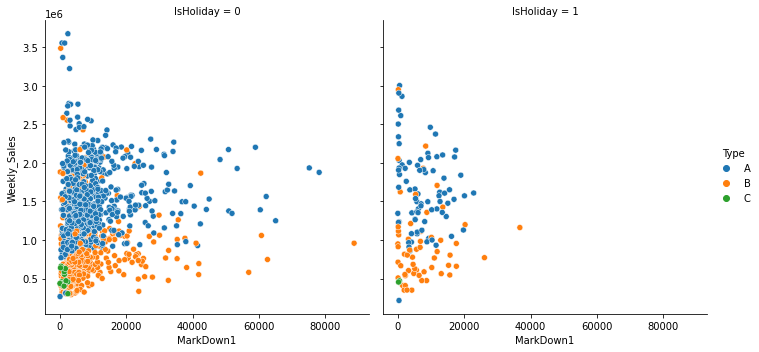

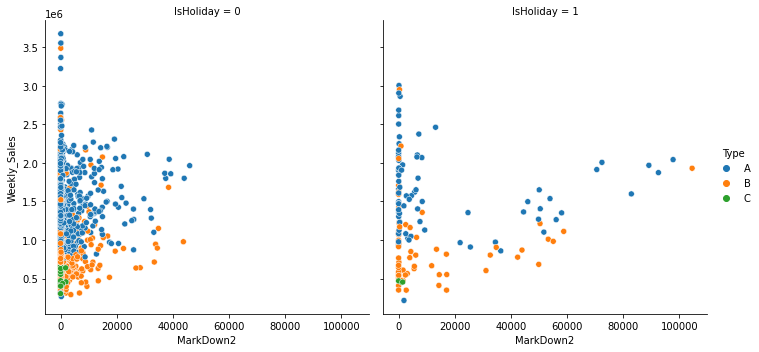

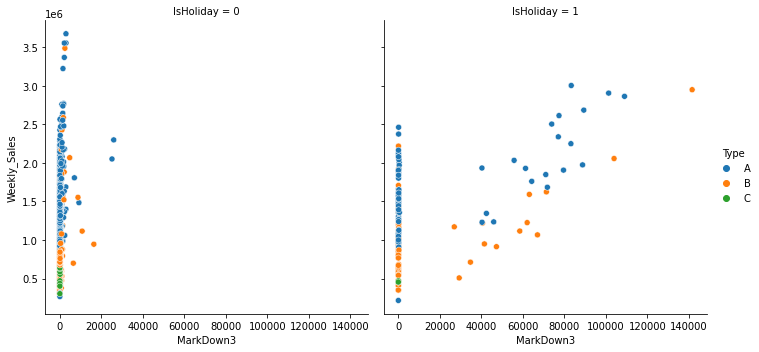

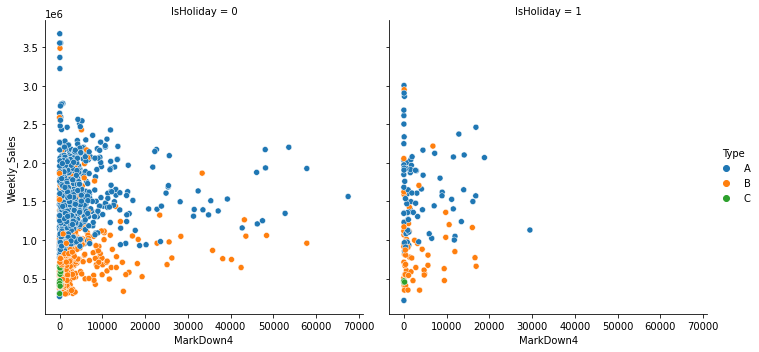

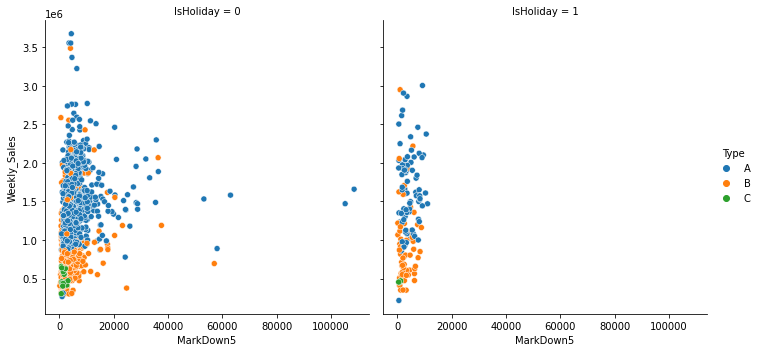

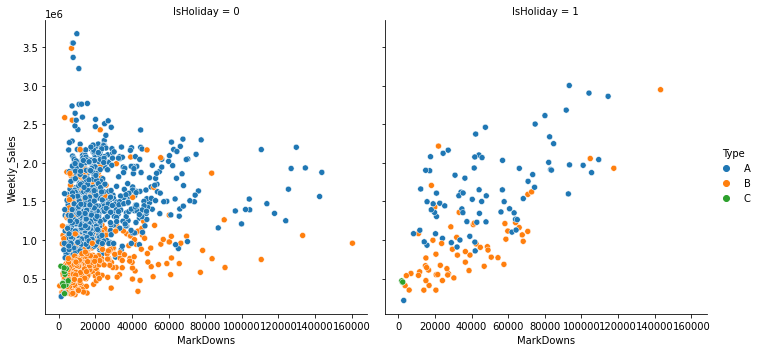

In [8]:
import seaborn as sns

MDplotData=dataSetup(markdowns="all", CPI_Unemp=False, detailLvl="Store", PipelineLvl="Merge")

for i in range(1,6):
  sns.relplot(data=MDplotData, x="MarkDown%s" % i,y="Weekly_Sales",hue="Type",col="IsHoliday") 
sns.relplot(data=MDplotData, x="MarkDowns",y="Weekly_Sales",hue="Type",col="IsHoliday")


On MarkDown1-5 plots we see 3 different groups, small markdowns (<1000), intermediate markdowns (1000<m<50000) and big markdowns (50000<). That happens on both holiday and regular weeks, so maybe each group corrensponds to a different markdown type and sometimes one particular type is put in one markdown column or another.

If all markdowns are added so that effect is removed, we see that **in holiday weeks markdown effect on sales is quite noticeable, with a strong proportional relationship, whereas in the regular weeks the effect is more homogeneous**.

Given this conclusion, we will use the total markdowns column as an input for machine learning instead of each individual column.

# **2. Machine Learning and adaptation to missing data**

As we have already seen, there are date intervals on the dataset in which some variables are missing. We can make a division of the dataset date range according to the available variables:

| Range | MarkDowns | CPI & Unemployment | Weekly_Sales |
| :----: | :----: | :----: | :----: | 
| **05/02/2010** - **04/11/2011** | No | Yes | **Yes** |
| **11/11/2011** - **26/10/2012** | Yes\* | Yes | **Yes** |  
| **02/11/2012** - **26/04/2013** | Yes\* | Yes | **No** |
| **03/05/2013** - **26/07/2013** | Yes\* | No | **No** |   

<font size="2">\*: *There are some weeks in which one or more markdowns are missing, so we can't compute the total markdown.*</font>

Missing data is a problem when we have to choose our algorithm input, which in our case is a neural network. The typical solution is somehow interpolate the missing data but this can distort our sample set.
However, in our case, we can try to solve this problem in a more straightforward way: **creating a neural network for each missing data combination.**

| Network | MarkDowns | CPI & Unemployment | Training range | Testing range |
| :----: | :----: | :----: | :----: | :----: | 
| **1** | No | No | 05/02/2010 - 26/10/2012 | 05/02/2010 - 26/07/2013 | 
| **2** | No | Yes | 05/02/2010 - 26/10/2012 | 05/02/2010 - 26/04/2013 |  
| **3** | Yes | No | 11/11/2011 - 26/10/2012 | 11/11/2011 - 26/07/2013 |
| **4** | Yes | Yes | 11/11/2011 - 26/10/2012 | 11/11/2011 - 26/04/2013 |

This way, depending of the available data, we can use one or many of those 4 networks:

| MarkDowns | CPI & Unemployment | Network 1 | Network 2  | Network 3 | Network 4 |    
| :----: | :----: | :----: | :----: | :----: | :----: |
| No | No | ✔ | - | - | - |
| No | Yes | ✔ | ✔ | - | - |
| Yes | No | ✔ | - | ✔ | - |
| Yes | Yes | ✔ | ✔ | ✔ | ✔ |

In order to test the performance of each network we will make 2 tests:
- **Overfitting test**: All the available training range (the records with sales data) is used for the training process. 10% of the data is used as the validation set. A high number of epochs (e=50) is applied to study the evolution of the error both sets and identify a possible overfitting regime.
- **Future prediction test**: Data is split from a given date. Data records previous to that date make the train set, whereas the following records make the test set, so we can evaluate the actual predictive performance of sales of records subsequent to the training date range.

 Making a simple train-test evaluation in the same date range isn't enough to evaluate the predictive performance, since in the future the variable distribution may be different, so predicting the future with present data may have extrapolation issues. For example if an input variable value increases abruptly in the future, the algorythm may have problems, since it has been trained with that variable in a different value range, with much lower values.
 
 This method shows us if a given algorithm adapts well to future data.

## **Data model class and its methods definition**

First, the **data model** class is defined, which gets a **set of input data** and applies it to a **multilayer neural network**. Then, we define some methods which return the results of the network training and testing processes.

The hidden layers of the neural network are the same for the 4 cases, since the difference of the number of input neurons between each network is relatively small (138-141). The network has the following structure.

| Layer | Neurons | Activation F. |
| ---- | :----: | :----: |
| Input | ~140 | sigmoid |
| Hidden 1 | 80 | sigmoid |
| Hidden 2 | 40 | sigmoid |
| Hidden 3 | 20 | selu |
| Output | 1 | - |


Since this is a regression task with quite sparse sales values, it's not very convenient to apply an activation funtion to the output neuron.

In [9]:
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt

def prettyDate(date):
  '''
  Transforms datetime values to string with format 'dd/mm/aaaa'.
  '''
  date=pd.to_datetime(date)
  day=date.day
  month=date.month
  year=date.year
  return "%02d/%02d/%d" % (day,month,year)

class dataModel():
  def __init__(self, markdowns=True, CPI_Unemp=True, detailLvl="Dept", DnegWS="Keep", testSize=0.2, splitDate=None, futureTest=False, validation=True, verbose="auto"):
    '''
    Class initializer. Its parameters are::
    - markdowns: If the network input contains the total markdown variable.
    - CPI_Unemp: If the network input contains the CP and Unemployment variables.
    - detailLvl: If the input data is grouped by store or not. In our case, we don't group the data.
    - DnegWS: If we keep the negative Weekly_Sales or not. In our case, we keep them.
    - testSize: The test fraction of the dataset the random split case.
    - splitDate: The splitting date in case we use a date split.
    - futureTest: If we use a past-future split.
    - validation: If we use a validation set. In that case, we take the 10% of the train set as the validation set.
    - verbose: The network communication with the user in the training and testing processes (see Keras API).
    '''
    data=dataSetup(markdowns, CPI_Unemp, detailLvl, DnegWS, "Serve", testSize, splitDate, futureTest)
    self.markdowns=markdowns
    self.CPI_Unemp=CPI_Unemp
    self.splitDate=splitDate
    self.futureTest=futureTest

    self.detailLvl=detailLvl
    self.validation=validation
    self.verbose=verbose

    self.X_cols=data["X"]["cols"]
    self.y_col=data["y"]["col"]
    self.w_col=data["w"]["col"]
    self.d_col=data["d"]["col"]
    self.inputShape=data["X"]["shape"]

    self.X_train=data["X"]["train"]
    self.y_train=data["y"]["train"]
    self.w_train=data["w"]["train"]
    self.d_train=data["d"]["train"]

    self.X_test=data["X"]["test"]
    self.y_test=data["y"]["test"]
    self.w_test=data["w"]["test"]
    self.d_test=data["d"]["test"]

    self.X_scaler=data["X"]["scaler"]
    self.y_scaler=data["y"]["scaler"]

    self.model=keras.Sequential(
      [
      keras.Input(shape=self.inputShape),
      layers.Dense(name="Hidden1",units=80,activation="sigmoid"),
      layers.Dense(name="Hidden2",units=40,activation="sigmoid"),
      layers.Dense(name="Hidden3",units=20,activation="selu"), 
      layers.Dense(name="Output",units=1,activation=None) 
      ]
      )
    self.model.compile(optimizer="adam",loss="mean_squared_error",metrics=["mean_squared_error"])

    self.y_train_pred=None
    self.y_test_pred=None
  
  def fit(self, epochs=15):
    '''
    Trains the network with a given number of epochs.
    '''
    if self.validation==True: val=0.1
    else: val=0
    self.fitHistory=self.model.fit(
      x=self.X_train,
      y=self.y_train,
      batch_size=50,
      validation_split=val,
      sample_weight=self.w_train,
      epochs=epochs,
      verbose=self.verbose
      )
    self.y_train_pred=self.model.predict(self.X_train)

  def predict(self):
    '''
    Executes the test process.
    '''
    if self.futureTest==False and self.verbose!=0: self.model.evaluate(self.X_test,self.y_test,verbose=self.verbose)
    self.y_test_pred=self.model.predict(self.X_test)

  def evaluate(self):
    '''
    Returns the graphical comparison of predicted vs real sales of both train and test sets (only
    train set if past-future split is applied or we do an overfitting test).
    '''
    plots=[]
    if type(self.y_train_pred)!=type(None):
      plots.append("Training set")
      yTrain=self.y_scaler.inverse_transform(self.y_train)
      yTrainPred=self.y_scaler.inverse_transform(self.y_train_pred)
    if type(self.y_test_pred)!=type(None) and self.futureTest==False:
      plots.append("Testing set")
      yTest=self.y_scaler.inverse_transform(self.y_test)
      yTestPred=self.y_scaler.inverse_transform(self.y_test_pred)

    fig,ax=plt.subplots(ncols=len(plots), sharex=True, sharey=True,figsize=(5*len(plots),5),squeeze=False )
    pos=0
    for plot_ in plots:
      if plot_=="Training set":
        x=yTrain
        y=yTrainPred
        date0=prettyDate(self.d_train.min())
        date1=prettyDate(self.d_train.max())
        daterange= "%s - %s" % (date0,date1)
      if plot_=="Testing set" and yTest.sum()==yTest.sum():
        x=yTest
        y=yTestPred
        date0=prettyDate(self.d_test.min())
        date1=prettyDate(self.d_test.max())
        daterange= "%s - %s" % (date0,date1)
      ax[0,pos].scatter(x,y,s=1)
      ax[0,pos].set_xlabel("Real")
      ax[0,pos].set_ylabel("Pred")
      ax[0,pos].set_title(plot_ + ". %s" % daterange)
      ax[0,pos].plot(x,x, color="black")
      ax[0,pos].tick_params(axis='x', rotation=45)
      pos+=1
    title="Markdowns = %s, " % self.markdowns
    title+="CPI & Unemployment = %s " % self.CPI_Unemp
    fig.suptitle(title)
    plt.close(fig)
    return fig

  def data(self, dset="both"):
    '''
    Returns train and test data with their predicted output.
    '''
    dCol=self.d_col
    xCols=self.X_cols
    yCol=self.y_col
    storecols=[col for col in xCols if "Store_" in col]
    deptcols=[col for col in xCols if "Dept_" in col]

    dTrain=self.d_train
    xTrain=self.X_scaler.inverse_transform(self.X_train)
    yTrain=self.y_scaler.inverse_transform(self.y_train)

    dTest=self.d_test
    xTest=self.X_scaler.inverse_transform(self.X_test)
    yTest=self.y_scaler.inverse_transform(self.y_test)

    data={}

    if dset in ("train","both"):
      dataTrain=pd.DataFrame()
      dataTrain[dCol]=dTrain.ravel()
      dataTrain[xCols]=xTrain
      dataTrain[yCol]=yTrain.ravel()

      dataTrain["Store"]=dataTrain[storecols].idxmax(axis=1).apply(lambda x: x.split("_")[1])
      dataTrain=dataTrain.drop(columns=storecols)
      if self.detailLvl=="Dept":
        dataTrain["Dept"]=dataTrain[deptcols].idxmax(axis=1).apply(lambda x: x.split("_")[1])
        dataTrain=dataTrain.drop(columns=deptcols)

      if type(self.y_train_pred)!=type(None):
        yPredTrain=self.y_scaler.inverse_transform(self.y_train_pred)
        dataTrain[yCol+"_Pred"]=yPredTrain.ravel()
        dataTrain[yCol+"_Pred"]=dataTrain[yCol+"_Pred"].astype("float64")
      data["train"]=dataTrain
    if dset in ("test","both"):
      dataTest=pd.DataFrame()
      dataTest[dCol]=dTest.ravel()
      dataTest[xCols]=xTest
      dataTest[yCol]=yTest.ravel()

      #Es desfà el one-hit encoding per tornar a tenir les variables categòriques en una sola columna.
      dataTest["Store"]=dataTest[storecols].idxmax(axis=1).apply(lambda x: x.split("_")[1])
      dataTest["Store"]=dataTest["Store"].apply(lambda x: int(x)).astype("category") 
      dataTest=dataTest.drop(columns=storecols)
      if self.detailLvl=="Dept": 
        dataTest["Dept"]=dataTest[deptcols].idxmax(axis=1).apply(lambda x: x.split("_")[1])
        dataTest["Dept"]=dataTest["Dept"].apply(lambda x: int(x)).astype("category")
        dataTest=dataTest.drop(columns=deptcols)

      if type(self.y_test_pred)!=type(None):
        yPredTest=self.y_scaler.inverse_transform(self.y_test_pred)
        dataTest[yCol+"_Pred"]=yPredTest.ravel()
        dataTest[yCol+"_Pred"]=dataTest[yCol+"_Pred"].astype("float64")
      data["test"]=dataTest
      if dset!="both":
        return data[dset]
      else:
        return data

  def getTrainScore(self):
    '''
    Returns the overfitting test results.
    '''
    train=np.array(self.fitHistory.history['mean_squared_error'])
    epochs=[i+1 for i in range(len(train))]
    x_epochs=[1]+[i for i in range(5,len(train)+1,5)]
    fig=plt.figure()
    ax = fig.add_subplot()

    ax.plot(epochs,np.sqrt(train),label="Training set")
    try:
      val=np.array(self.fitHistory.history['val_mean_squared_error'])
      ax.plot(epochs,np.sqrt(val),label="Validation set")
    except:
      pass

    date0=prettyDate(self.d_train.min())
    date1=prettyDate(self.d_train.max())
    daterange= "%s - %s" % (date0,date1)

    ax.set_title("Training score. "+daterange)
    ax.set_xlabel("Epochs")
    ax.set_xticks(x_epochs)
    ax.set_ylabel("RMSE")
    ax.set_xlim(left=1)
    ax.legend()

    title="Markdowns = %s, " % self.markdowns
    title+="CPI & Unemployment = %s " % self.CPI_Unemp
    fig.suptitle(title)

    plt.close(fig)
    return fig
    
  def getTestPred(self, epochs=15):
    '''
    Returns the test set sales prediction.
    '''
    if type(self.y_train_pred)==type(None): self.fit(epochs)
    if type(self.y_test_pred)==type(None): self.predict()
    if self.detailLvl=="Store": cols=["Store"]
    else: cols=["Store", "Dept"]
    cols+=["Date"]
    if self.futureTest==False: cols+=[self.y_col]
    cols+=[self.y_col+"_Pred"]
    return self.data("test")[cols].round(2)

## **Overfitting test**

Each of the 4 neural networks are tested. The error is que root mean squared error (RMSE) with the standard scaling applied. Since the real RMSE is just the same but multiplied by a constant (the data variance), it doesn't affect the result.

<font size=2>*WARNING: The execution time of the first 2 plots can exceed 15 minutes. Load the pickle file with the results variable if you already have it.*</font> 

In [10]:
import pickle as p

def overfittingTest(MD,CU):
  dModel=dataModel(markdowns=MD, CPI_Unemp=CU, futureTest=True, validation=True,verbose=0) # S'agafa tot el rang d'entrenament con a conjunt d'entrenament, així que s'utilitza la separació passat-futur.
  dModel.fit(epochs=50)
  return dModel.getTrainScore()

ofT={}
bmap={False:0,True:1}
for MD in (False,True):
  md=bmap[MD]
  ofT[md]={}
  for CU in (False,True):
    cu=bmap[CU]
    ofT[md][cu]=overfittingTest(MD,CU)

2021-12-23 09:21:09.076227: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 09:21:09.170112: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 09:21:09.170838: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-12-23 09:21:09.172235: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compil

In [11]:
# Save results variable.
import pickle as p

with open("ofT.p","wb") as file:
  p.dump(ofT,file)

In [12]:
# Load results variable.
import pickle as p

with open("ofT.p","rb") as file:
  ofT = p.load(file)

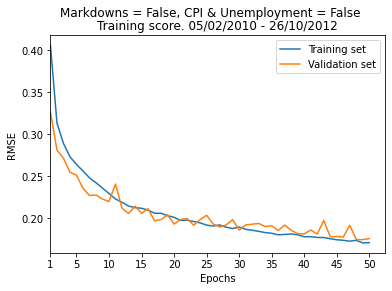

In [13]:
ofT[0][0]

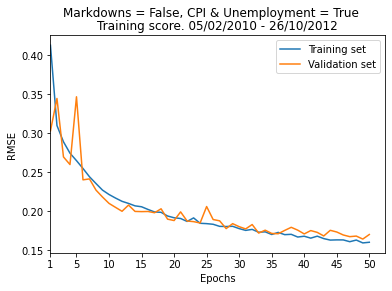

In [14]:
ofT[0][1]

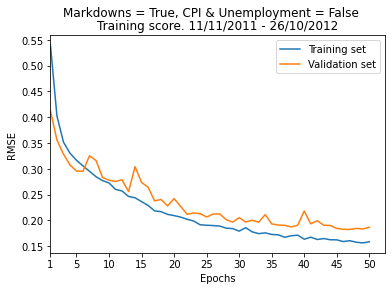

In [15]:
ofT[1][0]

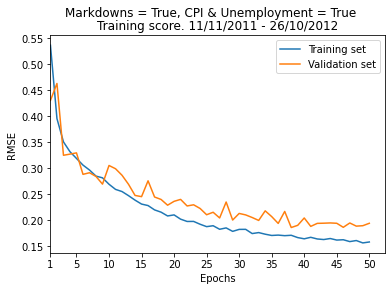

In [16]:
ofT[1][1]

The validation set error of the 2 last networks already reaches a stationary regime, while the other 2 ones still have room for improvement. This is due to the fact that the 2 first plots correspond to networks with a train set date range 2 times larger than the others, so they need more epochs to converge.

Besides, from 20 epochs the performance improvement rate decreases substantially.

## **Future prediction test**

In this test we will evaluate the ability of our network to predict data in a date range after the training one. For our case we do 2 different evaluations:

- On one side, we have the networks without markdowns, those have a wide training date range (05/02/2010 - 26/10/2012), so we can predit the last year with sales data (26/10/2011 - 26/10/2012) using prior data (05/02/2010 - 19/10/2011).
  
  In this case, the training test contains records of every week of the year (some of them with records of 2 different years)
 

- On the other side, the train set date range is less than a year (11/11/2011 - 26/10/2012), so no matter how we do it, the test set records will fall into unlearnt weeks.

  In this case, we do several date splits of the trainable data to see how the predictive performance evolves if while it learns more weeks of the year. The splits are:

| % | Train set | Test set |
| :---: | :---: | :---: |
| 67 | 11/11/2011 - 29/06/2012 | 06/07/2012 - 26/10/2012 |
| 80 | 11/11/2011 - 17/08/2012 | 24/08/2012 - 26/10/2012 |
| 90 | 11/11/2011 - 21/09/2012 | 28/09/2012 - 26/10/2012 |

<font size=2>*WARNING: The execution time of results can exceed 30 minutes. Load the pickle file with the results variable if you already have it.*</font> 

In [17]:
def getsplitDate(frac):
  if frac==None:
    return "2011-10-26"
  else:
    fecha=pd.to_datetime("2011-11-11")+(pd.to_datetime("2012-10-26")-pd.to_datetime("2011-11-11"))*(frac/100)
    return "%d-%02d-%02d" % (fecha.year,fecha.month,fecha.day)

def futurePredictionEval(MD,CU,frac=None):
  spDate=getsplitDate(frac)
  dModel=dataModel(markdowns=MD, CPI_Unemp=CU, splitDate=spDate, validation=False,verbose=0)
  op={}
  op["data"]=dModel.getTestPred(epochs=20)
  op["fig"]=dModel.evaluate()
  return op

fpE={}
bmap={False:0,True:1}
for MD in (False,True):
  md=bmap[MD]
  fpE[md]={}
  for CU in (False,True):
    cu=bmap[CU]
    fpE[md][cu]={}
    if MD==False:
      fpE[md][cu]=futurePredictionEval(MD,CU)
    else:
      for frac in (67,80,90):
        fpE[md][cu][frac]=futurePredictionEval(MD,CU,frac)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

In [18]:
# Save results variable.
import pickle as p

with open("fpE.p","wb") as file:
  p.dump(fpE,file)

In [19]:
# Load results variable.
import pickle as p

with open("fpE.p","rb") as file:
  fpE=p.load(file)

#### **Without markdowns / Without CPI & Unemployment**

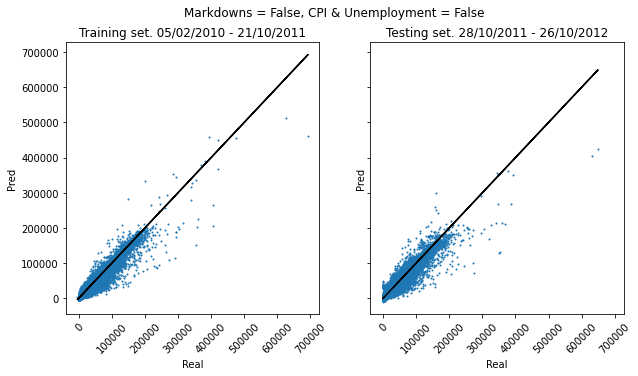

In [20]:
fpE[0][0]["fig"]

#### **Without markdowns / With CPI & Unemployment**

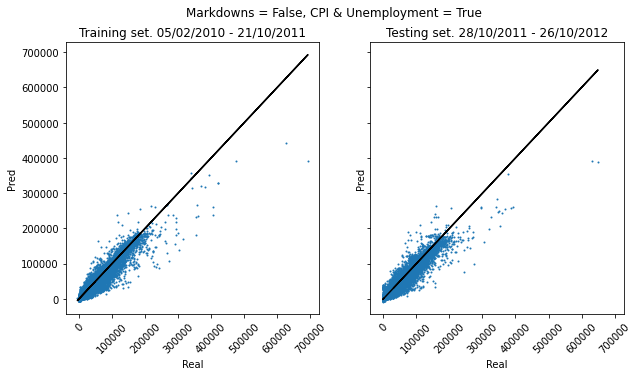

In [21]:
fpE[0][1]["fig"]

#### **With markdowns / Without CPI & Unemployment**

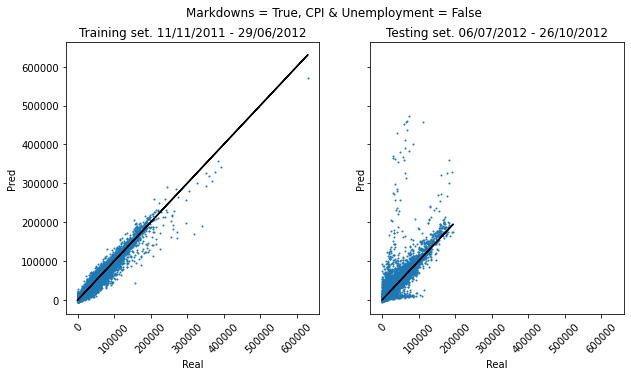

In [22]:
fpE[1][0][67]["fig"]

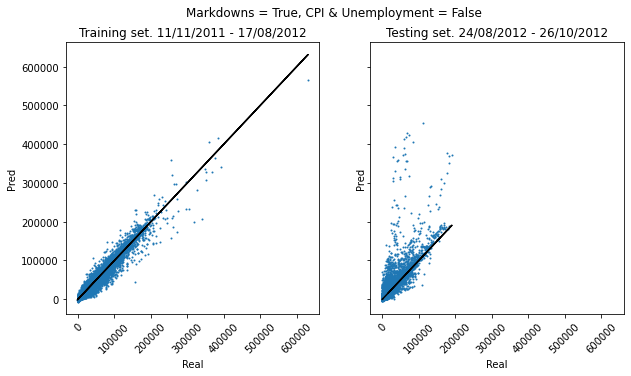

In [23]:
fpE[1][0][80]["fig"]

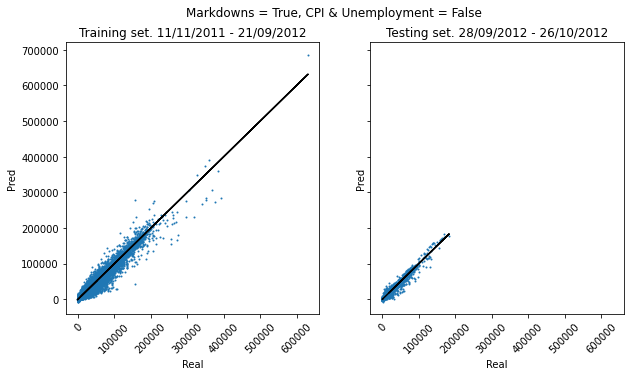

In [24]:
fpE[1][0][90]["fig"]

#### **With markdowns / With CPI & Unemployment**

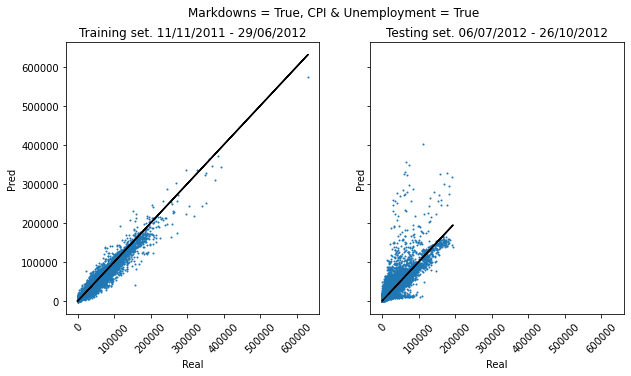

In [25]:
fpE[1][1][67]["fig"]

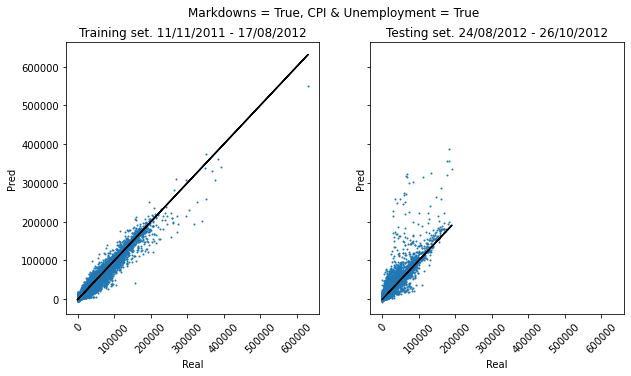

In [26]:
fpE[1][1][80]["fig"]

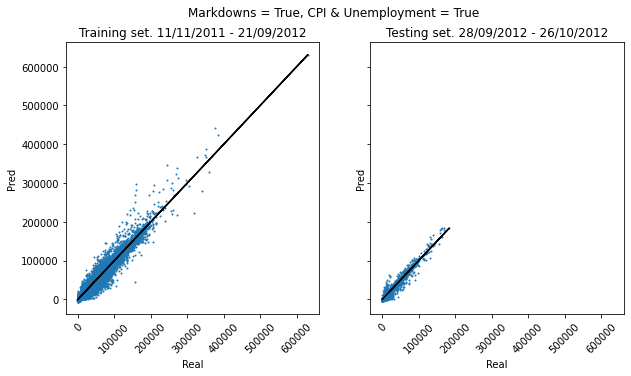

In [27]:
fpE[1][1][90]["fig"]

The networks without markdowns can predict the next year to the train set quite well, whereas the networks with markdowns, with less training records, show worse results. However, as it learns more weeks, the prediction improves, to the point that in the 90% of the available training data the prediction is quite accurate, though the test set is quite close to the end of the training set (less than a month of difference). 

We can conclude that our networks have a reasonable predictive performance.

### **Future prediction with a weightened mean**

In ordert to make the actual prediction, we will make the weightened mean of the prediction of the available neural networks for each testing record, since we have to take into account the amount of training data and the quantity of input variables of each network.

To see if this method is reasonable, we will take the results of the previous test and we will use them to predict the last month with sales values (28/09/2012 - 26/10/2012). Networks without markdowns have training data up to 21/10/2011 and the others up to 21/09/2021.

The weights have been assigned arbitrarily with the following values:

| Network | MarkDowns | CPI & Unemployment | Weight |
| :----: | :----: | :----: | :----: | 
| **1** | No | No | 2 |
| **2** | No | Yes | 2.2 |  
| **3** | Yes | No | 0.8 |
| **4** | Yes | Yes | 1 |

In [28]:
def fpEfix(data):
  op=data
  return op[["Store","Dept", "Date","Weekly_Sales_Pred"]]


def modmean(MD0CU0,MD0CU1,MD1CU0,MD1CU1,weights):
  pred=[MD0CU0,MD0CU1,MD1CU0,MD1CU1]
  weight=weights
  totalw=0
  mean=0
  allnans=True
  for i in range(4):
    if pred[i]==pred[i]:
      totalw+=weight[i]
      mean+=weight[i]*pred[i]
      allnans=False
  if allnans==False:
    return mean/totalw
  else: return np.nan


fusedPreds=salesV2.copy()
for MD in (0,1):
  for CU in (0,1):
    if MD==1:
      rightDF=fpEfix(fpE[MD][CU][90]["data"])
    else:
      rightDF=fpEfix(fpE[MD][CU]["data"])
    fusedPreds=fusedPreds.merge(rightDF, how="left", on=["Store","Dept", "Date"])
    colname="MD%s_CU%s" % (MD,CU)
    fusedPreds.rename(columns = {'Weekly_Sales_Pred':'WSPred_'+colname}, inplace=True)
fusedPreds["WSPred_ModMean"]=fusedPreds.apply(lambda x: modmean(x.WSPred_MD0_CU0,x.WSPred_MD0_CU1,x.WSPred_MD1_CU0,x.WSPred_MD1_CU1, [2,2.2,0.9,1]),axis=1)

plotdata=fusedPreds.query("Date > '2012-09-21' & Date <= '2012-10-26'")

In [29]:
# Save results variable.
import pickle as p
with open("fpEmean.p","wb") as file:
  p.dump(plotdata,file)

In [30]:
# Load results variable.
import pickle as p

with open("fpEmean.p","rb") as file:
  plotdata=p.load(file)

Text(0.5, 0.98, 'Future prediction test. 28/09/2012- 26/10/2012')

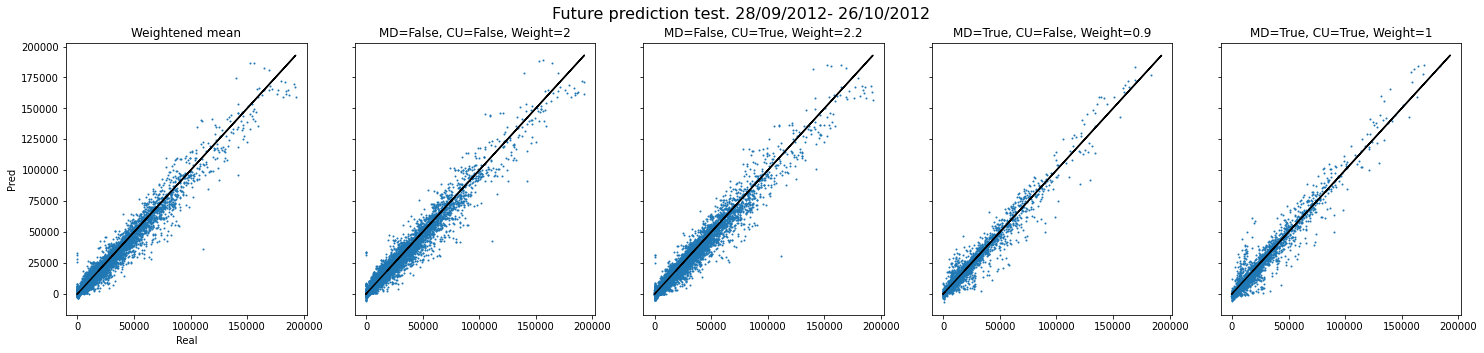

In [31]:
meanweights=[2,2.2,0.9,1]
x,xlab=plotdata["Weekly_Sales"],"Real"
y0,y0lab=plotdata["WSPred_ModMean"],"Weightened mean"
y1,y1lab=plotdata["WSPred_MD0_CU0"],"MD=False, CU=False, Weight="+str(meanweights[0])
y2,y2lab=plotdata["WSPred_MD0_CU1"],"MD=False, CU=True, Weight="+str(meanweights[1])
y3,y3lab=plotdata["WSPred_MD1_CU0"],"MD=True, CU=False, Weight="+str(meanweights[2])
y4,y4lab=plotdata["WSPred_MD1_CU1"],"MD=True, CU=True, Weight="+str(meanweights[3])

fig, ax = plt.subplots(ncols=5,sharex=True, sharey=True,figsize=(25,5))
ax[0].set_xlabel("Real")
ax[0].set_ylabel("Pred")

ax[0].scatter(x,y0,s=1)
ax[0].plot(x,x,color="black")
ax[0].set_title(y0lab)
ax[1].scatter(x,y1,s=1)
ax[1].plot(x,x,color="black")
ax[1].set_title(y1lab)
ax[2].scatter(x,y2,s=1)
ax[2].plot(x,x,color="black")
ax[2].set_title(y2lab)
ax[3].scatter(x,y3,s=1)
ax[3].plot(x,x,color="black")
ax[3].set_title(y3lab)
ax[4].scatter(x,y4,s=1)
ax[4].plot(x,x,color="black")
ax[4].set_title(y4lab)

daterange= "28/09/2012- 26/10/2012"
fig.suptitle("Future prediction test. "+daterange,fontsize=16)

We see that **the weightened mean method adapts quite well to the missing data problem**.

# **3. Future sales prediction**

Finally we make the prediction of future sales with our fully trained networks (using all their trainable data). Networks with markdowns have a training data almost 2 years shorter than the others, thought their training data is overall closer to the data we want to predict and, of course, they take into account markdowns effect on sales. With all of this, the weights will have the following values:

| Network | MarkDowns | CPI & Unemployment | Weight |
| :----: | :----: | :----: | :----: | 
| **1** | No | No | 1.8 |
| **2** | No | Yes | 2 |  
| **3** | Yes | No | 1 |
| **4** | Yes | Yes | 1.2 |

Also, each network is trained with 30 epochs.

In [32]:
def futurePrediction(MD,CU):
  dModel=dataModel(markdowns=MD, CPI_Unemp=CU, validation=False, futureTest=True, verbose=0)
  op=dModel.getTestPred(epochs=30)
  return op

fPred={}
bmap={False:0,True:1}
for MD in (False,True):
  md=bmap[MD]
  fPred[md]={}
  for CU in (False,True):
    cu=bmap[CU]
    fPred[md][cu]=futurePrediction(MD,CU)

/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  self[col] = igetitem(value, i)
/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:181: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
/opt/conda/lib/python3.7/site-packages/pandas/core/frame.py:3678: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) inste

In [33]:
# Save results variable.
import pickle as p
with open("fPred.p","wb") as file:
  p.dump(fPred,file)

In [34]:
# Load results variable.
import pickle as p

with open("fPred.p","rb") as file:
  fPred=p.load(file)

In [35]:
futureSales=dataMerge(features, futuresales, Detail="Dept")

def modmean(MD0CU0,MD0CU1,MD1CU0,MD1CU1,weights):
  pred=[MD0CU0,MD0CU1,MD1CU0,MD1CU1]
  weight=weights
  totalw=0
  mean=0
  allnans=True
  for i in range(4):
    if pred[i]==pred[i]:
      totalw+=weight[i]
      mean+=weight[i]*pred[i]
      allnans=False
  if allnans==False:
    return mean/totalw
  else: return np.nan

finalPred=futureSales.copy()

for MD in (0,1):
  for CU in (0,1):
    rightDF=fPred[MD][CU][["Store","Dept", "Date","Weekly_Sales_Pred"]]
    finalPred=finalPred.merge(rightDF, how="left", on=["Store","Dept", "Date"])
    colname="MD%s_CU%s" % (MD,CU)
    finalPred.rename(columns = {'Weekly_Sales_Pred':'WSPred_'+colname}, inplace=True)
finalPred["WSPred_ModMean"]=finalPred.apply(lambda x: modmean(x.WSPred_MD0_CU0,x.WSPred_MD0_CU1,x.WSPred_MD1_CU0,x.WSPred_MD1_CU1,[1.8,2,1,1.2]),axis=1)

finalPred=finalPred.query("WSPred_ModMean==WSPred_ModMean").drop(["Weekly_Sales","Weight"],axis=1)

In [36]:
finalPred

,Store,Dept,Date,IsHoliday,Type,Size,Temperature,Fuel_Price,MarkDown1,MarkDown2,...,CPI,Unemployment,Week,Year,MarkDowns,WSPred_MD0_CU0,WSPred_MD0_CU1,WSPred_MD1_CU0,WSPred_MD1_CU1,WSPred_ModMean
143,1,1,2012-11-02,0,A,151315.0,55.32,3.386,6766.44,5147.70,...,223.462779,6.573,44,2012,18342.28,25957.82,31405.93,19891.27,20754.48,25722.097000
144,1,2,2012-11-02,0,A,151315.0,55.32,3.386,6766.44,5147.70,...,223.462779,6.573,44,2012,18342.28,41870.75,50065.54,41826.62,46781.01,45577.043667
145,1,3,2012-11-02,0,A,151315.0,55.32,3.386,6766.44,5147.70,...,223.462779,6.573,44,2012,18342.28,7969.58,13087.13,10001.37,12511.21,10922.387667
146,1,4,2012-11-02,0,A,151315.0,55.32,3.386,6766.44,5147.70,...,223.462779,6.573,44,2012,18342.28,36327.07,35212.90,34283.41,36829.94,35715.644000
147,1,5,2012-11-02,0,A,151315.0,55.32,3.386,6766.44,5147.70,...,223.462779,6.573,44,2012,18342.28,28904.17,25106.13,33888.96,28875.65,28463.251000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
136339,45,94,2013-07-26,0,B,118221.0,76.06,3.804,212.02,851.73,...,NaN,NaN,30,2013,2941.26,2688.18,NaN,5016.61,NaN,3519.762143
136340,45,95,2013-07-26,0,B,118221.0,76.06,3.804,212.02,851.73,...,NaN,NaN,30,2013,2941.26,60623.91,NaN,54153.92,NaN,58313.199286
136341,45,96,2013-07-26,0,B,118221.0,76.06,3.804,212.02,851.73,...,NaN,NaN,30,2013,2941.26,980.21,NaN,7927.21,NaN,3461.281429
136342,45,97,2013-07-26,0,B,118221.0,76.06,3.804,212.02,851.73,...,NaN,NaN,30,2013,2941.26,6534.79,NaN,5887.72,NaN,6303.693571
